In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
torch.manual_seed(4701)
np.random.seed(4701)

# code taken & adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

# Variables all proccesses need access to
# train_dir = '../../dataset/train/'
# validation_dir = '../../dataset/validation/'
load_mode = False
data_dir = '../../dataset/'
model_name = 'resnet'
num_classes = 10
batch_size = 8
num_epochs = 20
input_size = 224 # 224 x 224 images expected for resnet
fast_training = False

def eval(model, dataloader):
    model.eval()
    running_corrects = 0
    incorrects, corrects = [], []
    for data, labels in tqdm(dataloader):
        data = data.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            incorrects += [x.item() for x in preds[preds != labels.data]]
            corrects += [x.item() for x in preds[preds == labels.data]]

    return running_corrects.double() / len(dataloader.dataset), corrects, incorrects

def train_model(model, dataloaders, criterion, optimizer, num_epochs=15, speed=True):
    """
    Returns a trained model. 
    
    Trains the input model using the provided data, criterion, and optimizer.

    Parameter model: model to be trained

    Parameter dataloaders: dictionary of dataloaders for training and validation
    Precondition: dataloders bound to keys 'train' and 'val'

    Parameter criterion: criterion for evaluating loss

    Parameter optimizer: optimizer to be used when training

    Parameter num_epochs: number of epochs to train

    """
    since = time.time()

    train_history, val_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                if speed:
                    continue
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward pass (if training)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                if speed:
                    train_history.append(epoch_acc)
                else:
                    epoch_acc, _, _ = eval(model, dataloaders['train'])
                    train_history.append(epoch_acc)
            else:
                val_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print(train_history, val_history)
    return model, train_history, val_history

def histogram(counts, n = 10):
    """
    Returns a histogram of the input list of counts

    Histogram takes in a list with values in the range 0,...,n and returns a list 
    where the ith element is the number of times i appeared in counts
    """
    hist = [0]*n
    for d in counts:
        hist[d] += 1
    return hist

def freeze(model):
    """
    Freezes every layer in the model.

    By freezing each layer, no updates are made to the weights of the model
    when training.
    """
    for param in model.parameters():
        param.requires_grad = False

def initialize_model(num_classes, pretrain=True):
    """
    Returns an initialized resnet=18 model.

    Initializes a resnet-18 model. If pretrained, then we
    use the pretrained weights and freeze the model. Otherwise,
    a fresh model with resnet-18 architecture is used. A linear
    layer is appended so the output is num_classes.
    """
    model = models.resnet18(pretrained=pretrain)
    if pretrain:
        freeze(model)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model


def calc_mean_std(dataloader):
    """
    Returns a list of the average RGB values and a list of the standard of
    the RGB values.

    Extracts the mean and standard of RGB values of every image in dataloader
    and then returns the average.

    Parameter dataloader: images to find the mean and standard of
    Precondition: dataloader is a Torch dataloader object

    CITATION: This function was taken and adapted from the following source:
        https://forums.fast.ai/t/image-normalization-in-pytorch/7534/7
    """
    mean = []
    std = []

    # Find and append the mean and standard of each image in dataloader
    for data in dataloader:
        img, _ = data
        batch_mean = torch.mean(img, (0,2,3))
        batch_std = torch.std(img, (0,2,3))

        mean.append(batch_mean)
        std.append(batch_std)

    # Find and return the mean and standard of every image in dataloader
    mean = np.mean([m.numpy() for m in mean], axis=0)
    std = np.mean([s.numpy() for s in std], axis=0)

    return mean, std

def preprocess_data():
    """
    Returns the transformation necessary to normalize the image data.

    Creates a normalization transformation that results in the training data
    having a mean of 0 and a standard deviation of 1.
    """
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200)
    ])

    # Creates a dataloader object for the training and validation sets
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), \
        transform)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, \
        batch_size=batch_size, shuffle=True, num_workers=4)

    mean, std = calc_mean_std(train_dataloader)

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200),
        transforms.Normalize(mean,std)
    ])


if __name__ == '__main__':
    print('GPU Available: ', torch.cuda.is_available())
    model_ft = initialize_model(num_classes)
    transformations = preprocess_data()

    print("Initializing Datasets and Dataloaders...")
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x if x == 'train' else 'validation'), transformations) for x in ['train', 'val']}
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    classes = image_datasets['train'].classes

    # Determine device (GPU if available, else CPU) & send model to it
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_ft = model_ft.to(device)

    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    # params_to_update = model_ft.parameters()
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
    # Setup the loss fxn    
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate
    if not load_mode:
        model_ft, train_history, val_history = train_model(model_ft, 
                                                           dataloaders_dict, 
                                                           criterion, optimizer_ft, 
                                                           num_epochs=num_epochs,
                                                           speed=fast_training)
        torch.save(model_ft, 'model')
        torch.save(train_history, 'train_history')
        torch.save(val_history, 'val_history')
    else:
        model_ft = torch.load('model')
        model_ft.to(device)
        train_history = torch.load('train_history')
        val_history = torch.load('val_history')
    
    val_acc, corrects, incorrects = eval(model_ft, dataloaders_dict['val'])
    print('Validation accuracy {:.2f}%'.format(val_acc*100))
    hist_corrects = histogram(corrects)
    hist_incorrects = histogram(incorrects)
    total_correct = sum(hist_corrects)
    total_incorrect = sum(hist_incorrects)
    print([(i, x) for i, x in enumerate(classes)])
    print([int(100*x/(total_correct+total_incorrect)) for x in hist_corrects])
    print([int(100*x/(total_correct+total_incorrect)) for x in hist_incorrects])

    train_acc, corrects, incorrects = eval(model_ft, dataloaders_dict['train'])
    print('Train accuracy {:.2f}%'.format(train_acc*100))
    hist_corrects = histogram(corrects)
    hist_incorrects = histogram(incorrects)
    total_correct = sum(hist_corrects)
    total_incorrect = sum(hist_incorrects)
    print([int(100*x/(total_correct+total_incorrect)) for x in hist_corrects])
    print([int(100*x/(total_correct+total_incorrect)) for x in hist_incorrects])
    

GPU Available:  True


  0%|                         | 0/280 [00:00<?, ?it/s]

Initializing Datasets and Dataloaders...
Epoch 0/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 1.1026 Acc: 0.6790


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.4041 Acc: 0.9044

Epoch 1/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.5151 Acc: 0.8594


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2897 Acc: 0.9210

Epoch 2/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.4004 Acc: 0.8871


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2420 Acc: 0.9376

Epoch 3/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.3594 Acc: 0.9045


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2254 Acc: 0.9356

Epoch 4/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.3392 Acc: 0.9031


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2601 Acc: 0.9106

Epoch 5/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.3075 Acc: 0.9076


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2109 Acc: 0.9397

Epoch 6/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.3102 Acc: 0.9103


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2184 Acc: 0.9335

Epoch 7/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2724 Acc: 0.9143


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2241 Acc: 0.9252

Epoch 8/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2807 Acc: 0.9121


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2170 Acc: 0.9314

Epoch 9/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2679 Acc: 0.9179


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1898 Acc: 0.9439

Epoch 10/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2335 Acc: 0.9281


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2050 Acc: 0.9459

Epoch 11/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2569 Acc: 0.9259


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1972 Acc: 0.9459

Epoch 12/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2274 Acc: 0.9295


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1913 Acc: 0.9418

Epoch 13/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2357 Acc: 0.9295


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1784 Acc: 0.9480

Epoch 14/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2243 Acc: 0.9308


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1951 Acc: 0.9418

Epoch 15/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2154 Acc: 0.9321


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2012 Acc: 0.9397

Epoch 16/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2309 Acc: 0.9228


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.2105 Acc: 0.9272

Epoch 17/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2078 Acc: 0.9366


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1875 Acc: 0.9439

Epoch 18/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.2147 Acc: 0.9375


  0%|                         | 0/280 [00:00<?, ?it/s]

val Loss: 0.1846 Acc: 0.9376

Epoch 19/19
----------


  0%|                         | 0/280 [00:00<?, ?it/s]

train Loss: 0.1994 Acc: 0.9424


100%|█████████████████| 61/61 [00:06<00:00,  9.23it/s]


val Loss: 0.2376 Acc: 0.9293

Training complete in 9m 39s
Best val Acc: 0.948025
[tensor(0.9174, device='cuda:0', dtype=torch.float64), tensor(0.9371, device='cuda:0', dtype=torch.float64), tensor(0.9594, device='cuda:0', dtype=torch.float64), tensor(0.9612, device='cuda:0', dtype=torch.float64), tensor(0.9527, device='cuda:0', dtype=torch.float64), tensor(0.9679, device='cuda:0', dtype=torch.float64), tensor(0.9674, device='cuda:0', dtype=torch.float64), tensor(0.9688, device='cuda:0', dtype=torch.float64), tensor(0.9701, device='cuda:0', dtype=torch.float64), tensor(0.9799, device='cuda:0', dtype=torch.float64), tensor(0.9799, device='cuda:0', dtype=torch.float64), tensor(0.9821, device='cuda:0', dtype=torch.float64), tensor(0.9804, device='cuda:0', dtype=torch.float64), tensor(0.9817, device='cuda:0', dtype=torch.float64), tensor(0.9821, device='cuda:0', dtype=torch.float64), tensor(0.9817, device='cuda:0', dtype=torch.float64), tensor(0.9839, device='cuda:0', dtype=torch.float64), 

  0%|                         | 0/280 [00:00<?, ?it/s]

Validation accuracy 94.80%
[(0, 'bald_eagle'), (1, 'barn_owl'), (2, 'belted_kingfisher'), (3, 'blue_jay'), (4, 'chipping_sparrow'), (5, 'osprey'), (6, 'red_bellied_woodpecker'), (7, 'red_tailed_hawk'), (8, 'red_winged_blackbird'), (9, 'tree_swallow')]
[10, 8, 8, 9, 10, 8, 9, 10, 9, 8]
[0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


100%|███████████████| 280/280 [00:10<00:00, 26.15it/s]

Train accuracy 98.17%
[10, 9, 9, 10, 10, 8, 9, 10, 9, 9]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
def plot_confusion_matrix(true, preds, classes, title):
    cmatrix = confusion_matrix(true, preds)
    threshold = np.min(np.diagonal(cmatrix))
    fig, ax = plt.subplots()
    ax.set(xticks=np.arange(cmatrix.shape[1]),
           yticks=np.arange(cmatrix.shape[0]),
           xticklabels=classes,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label',
           title=title)
    ax.tick_params(axis='x', labelrotation=90)
    for i in range(cmatrix.shape[0]):
        for j in range(cmatrix.shape[1]):
            if cmatrix[i,j] > 0:
                ax.text(j, i, cmatrix[i, j], ha='center', va='center', color='white' if cmatrix[i, j] < threshold else 'black')
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    ax.imshow(cmatrix)
    plt.savefig('figs/confusionmatrix.png')
    

In [61]:
def get_labels_and_predictions(model, dataloader):
    preds, labels = [], []
    for data, label in tqdm(dataloader):
        data = data.to(device)
        output = model(data)
        _, pred = torch.max(output, 1)
        if len(label) != len(pred):
            print('UH OH', len(label), len(pred), label, pred)
        labels.append(label.detach().numpy())
        preds.append(pred.cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0)
    labels = np.concatenate(labels, axis=0)
    print(len(labels), len(preds))
    return preds, labels

In [62]:
val_data = []
val_labels = []
for batch, labels in dataloaders_dict['val']:
    batch.to(device)
    val_data = batch
    val_labels = labels
    break

val_data = val_data.to(device)
outputs = model_ft(val_data)
_, val_preds = torch.max(outputs, 1)
val_preds = val_preds.cpu().detach().numpy()
print(val_labels, val_preds)

tensor([4, 8, 9, 7, 0, 2, 6, 1]) [4 8 9 7 0 2 6 1]


In [63]:
val_preds_full, val_true_full = get_labels_and_predictions(model_ft, dataloaders_dict['val'])

100%|█████████████████| 61/61 [00:06<00:00,  9.02it/s]

481 481


In [64]:
train_preds_full, train_true_full = get_labels_and_predictions(model_ft, dataloaders_dict['train'])

100%|███████████████| 280/280 [00:10<00:00, 26.28it/s]

2240 2240


In [65]:
print(len(val_preds_full[val_preds_full == val_true_full])/len(val_true_full), len(train_preds_full[train_preds_full == train_true_full]) /len(train_true_full))

0.9480249480249481 0.9816964285714286


In [66]:
print(val_preds_full)
print(val_true_full)

[4 3 7 0 9 0 3 9 8 4 6 8 3 8 3 4 2 0 9 7 5 8 3 6 3 3 8 4 2 2 7 7 4 0 3 4 8
 2 6 1 1 7 7 5 5 5 2 0 3 3 7 9 2 2 7 4 7 2 3 5 3 7 9 1 1 5 5 7 5 3 8 7 3 5
 7 1 5 7 1 8 0 6 7 1 6 6 3 0 9 6 8 7 7 6 0 0 3 6 6 7 2 7 0 6 7 5 2 5 7 7 5
 5 2 2 9 0 3 4 0 0 5 8 5 1 3 2 7 6 5 9 1 8 3 2 2 1 7 3 7 2 9 9 8 8 2 3 1 1
 0 1 7 0 2 2 2 4 6 6 2 3 3 1 1 9 9 0 3 2 8 6 0 6 1 3 2 8 9 7 0 9 4 9 9 7 0
 4 1 8 9 0 3 1 6 9 7 2 8 0 5 5 7 8 7 5 6 4 7 9 9 0 0 9 6 4 0 5 7 9 8 4 6 5
 8 9 4 8 3 0 9 7 9 9 9 9 5 5 9 9 7 0 0 4 4 4 4 8 4 1 0 4 0 2 5 5 3 4 3 6 6
 0 3 3 3 2 0 9 2 1 7 8 2 1 4 5 0 5 8 1 1 1 5 8 3 2 1 9 5 6 5 4 4 6 4 9 2 1
 7 5 0 4 7 1 6 6 8 7 4 8 6 6 5 9 2 6 4 4 5 7 2 7 1 5 1 4 0 1 4 2 1 0 9 5 9
 2 3 3 1 8 0 3 1 7 2 3 1 9 7 6 0 9 7 3 1 2 9 7 0 8 2 2 3 0 8 1 2 1 5 7 4 7
 2 6 4 3 4 6 6 8 1 7 7 3 4 9 3 2 3 0 6 0 9 8 2 3 9 5 8 1 5 8 3 8 8 2 1 1 2
 3 8 5 8 8 0 8 4 0 6 6 7 6 4 6 4 7 6 4 3 3 9 4 6 5 7 0 4 1 4 0 0 6 8 2 9 6
 0 6 4 7 5 4 4 4 5 1 4 0 9 8 5 0 0 5 0 3 8 4 9 0 8 0 4 1 3 9 6 0 7 9 4 8 3]
[4 3 7 0 9 0 3 9 8 4 6 8

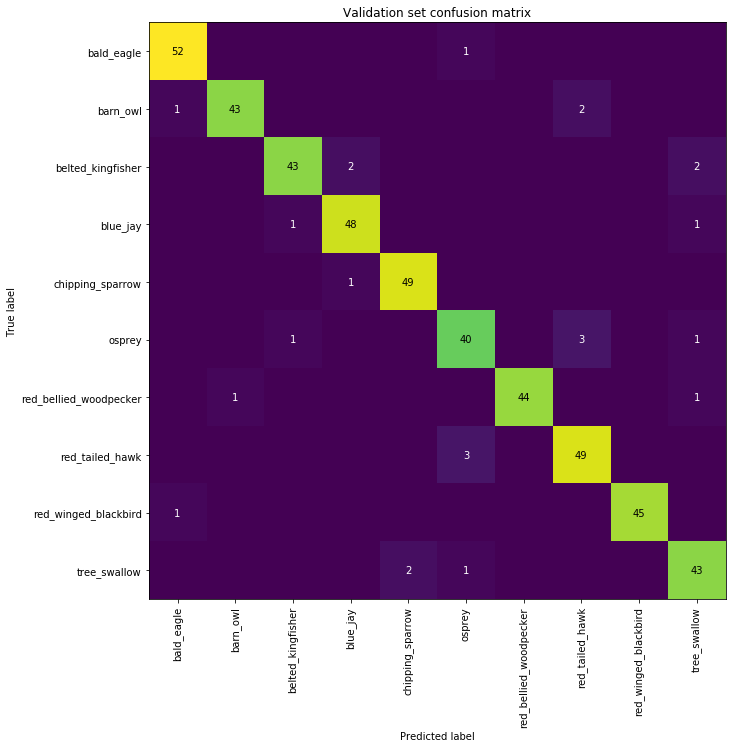

In [67]:
plot_confusion_matrix(val_true_full, val_preds_full, image_datasets['val'].classes, 'Validation set confusion matrix')

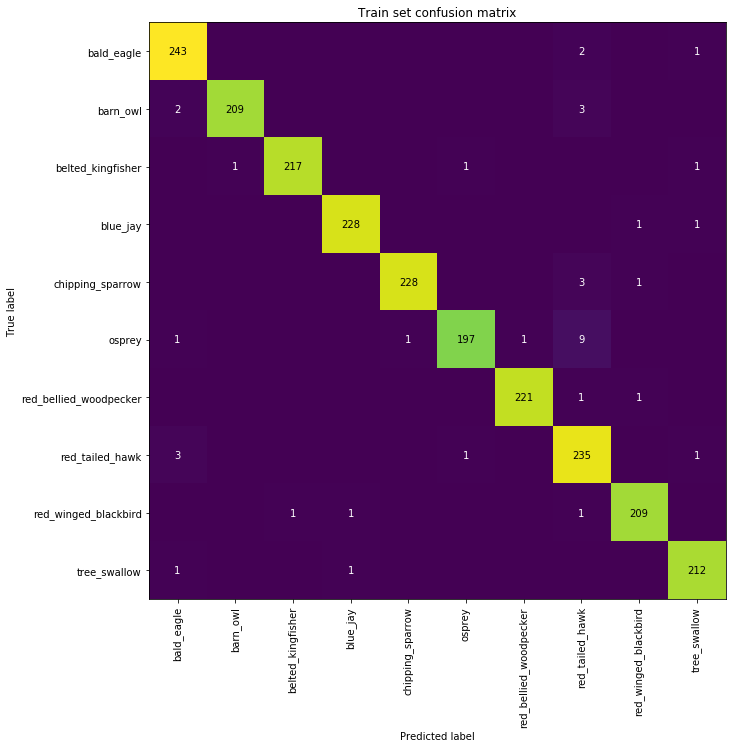

In [75]:
plot_confusion_matrix(train_true_full, train_preds_full, image_datasets['train'].classes, 'Train set confusion matrix')

In [16]:
print(len(val_true_full[val_true_full == 0]))

53


In [68]:
# Creates a dataloader object for the training and validation sets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms.Compose([transforms.ToTensor()]))
train_dataloader = torch.utils.data.DataLoader(train_dataset, \
    batch_size=batch_size, shuffle=True, num_workers=4)

mean, std = calc_mean_std(train_dataloader)

In [69]:
print(mean, std)

[0.4851213  0.50783634 0.47174433] [0.22539943 0.22473273 0.26877013]


In [70]:
def softmax(x):
    # https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [71]:
def k_mismatches(model, dataloader, k, predicate=(lambda x, y: x != y)):
    mismatches = []
    count = 0
    for data, label in dataloader:
        data = data.to(device)
        output = model(data)
        _, prediction = torch.max(output, 1)
        for i, (p, l) in enumerate(zip(prediction, label)):
            if predicate(p, l):
                count += 1
                mismatches.append((p.item(), l.item(), data[i].cpu().numpy(), softmax(output[i].cpu().detach().numpy())))
                if count == k:
                    return mismatches  
    return mismatches

In [72]:
k = 4
mismatches = k_mismatches(model_ft, dataloaders_dict['train'], k)

In [73]:
def unnormalize(img, mean, std):
    # img_unnormalized = std * (img + mean)
    img = copy.deepcopy(img)
    for i in range(img.shape[-1]):
        assert (i <= 2)
#         print(std[i], mean[i])
        img[:, :, i] *= std[i]
        img[:, :, i] += mean[i]
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\Jack\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


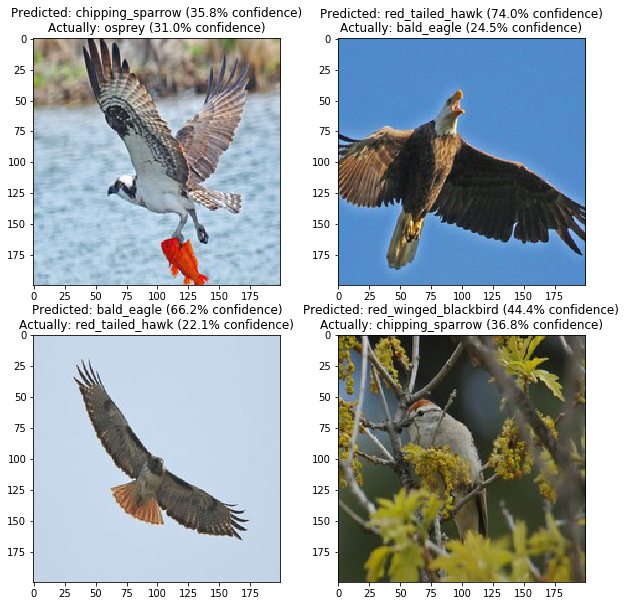

In [74]:
def display_k_mismatches(k, mismatches):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(10, 10)
    for i in range(k):
    # i = 1
    #     print(mismatches[i][3])
    #     print(classes)
        predicted = mismatches[i][0]
        actual = mismatches[i][1]
        axs[i//2, i % 2].set_title('Predicted: {} ({:.1f}% confidence)\nActually: {} ({:.1f}% confidence)'.format(
            classes[predicted],
            mismatches[i][3][predicted]*100,
            classes[mismatches[i][1]],
            mismatches[i][3][actual]*100
            ))

        # print(unnormalize(mismatches[i][2].transpose(1, 2, 0), mean, std))
        axs[i//2, i % 2].imshow(unnormalize(mismatches[i][2].transpose(1, 2, 0), mean, std))
    fig.savefig('figs/4mismatches.png')
    fig.show()
display_k_mismatches(k, mismatches)

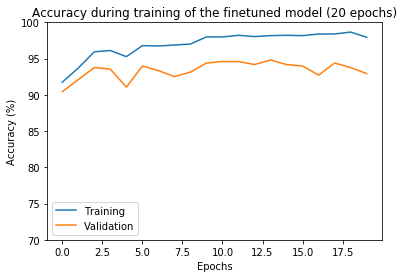

In [58]:
def training_plot(train_hist, val_hist):
    plt.plot([x*100 for x in train_hist], label='Training')
    plt.plot([x*100 for x in val_hist], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy during training of the finetuned model ('+str(len(train_hist))+' epochs)')
    plt.legend()
    plt.ylim(70, 100)
#     plt.xlim(0, len(train_hist))
    plt.savefig('figs/training_acc_plot.png')
    plt.show()
training_plot(train_history, val_history)